Det dataset som ges har inga labels - det  ̈ar upp till er att med hj ̈alp av klus-
tringsalgoritmer och tolkning av labels f ̈ors ̈oka ans ̈atta korrekt antal egentliga
klasser. Ans ̈att klasstillh ̈orighet till datasetet med hj ̈alp av klustringen (dvs -
klustringen ger en klass till varje observation som kan anv ̈andas vid visualis-
eringar)

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.cluster import KMeans
from sklearn.cluster import dbscan
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score


sns.set(rc = {'figure.figsize':(20,10)})


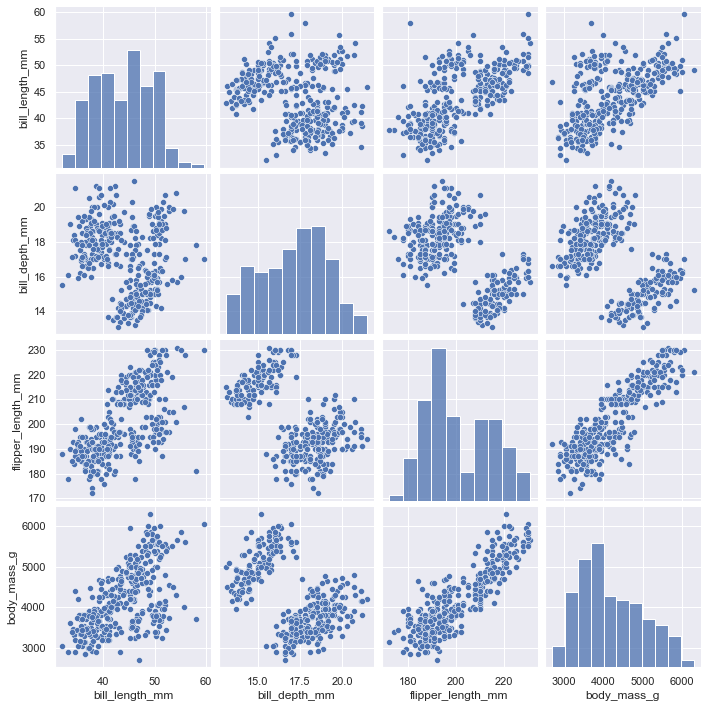

In [2]:
df = pd.read_csv('data/cluster_Data.csv')

sns.pairplot(df);

<AxesSubplot:>

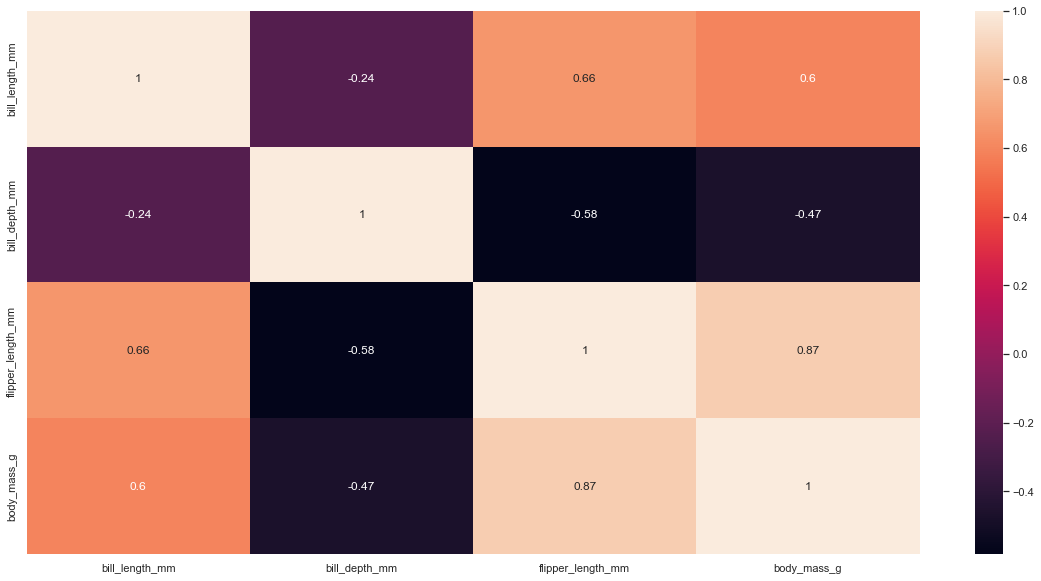

In [3]:
sns.heatmap(df.corr(), annot=True)

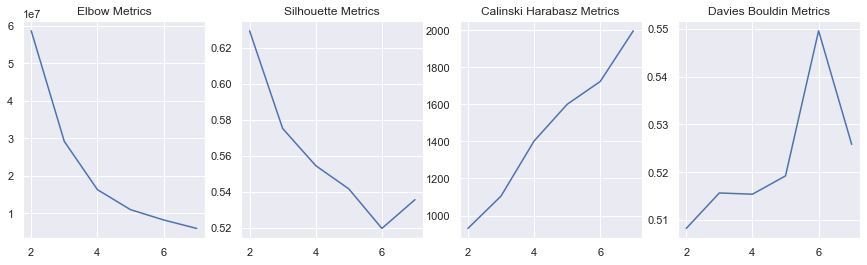

In [35]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

elbow_metrics, silhouette_metrics, ch_metrics, db_metrics = [], [], [], []
min, max = 2, 8
all_labels = {neighbours: [] for neighbours in range(min, max)}

for i in range(min,max):
    kmeans = KMeans(n_clusters=i, random_state=0).fit(df.to_numpy())
    labels = kmeans.labels_
    all_labels[i].append(labels)
    full_data = np.append(df.to_numpy(), labels.reshape(-1,1), axis = 1)

    sse = kmeans.inertia_
    elbow_metrics.append(sse)

    silhouette = silhouette_score(df.to_numpy(), labels)
    silhouette_metrics.append(silhouette)

    ch_score = calinski_harabasz_score(df.to_numpy(), labels)
    ch_metrics.append(ch_score)

    db_score = davies_bouldin_score(df.to_numpy(), labels)
    db_metrics.append(db_score)

fig, axs = plt.subplots(1, 4, figsize=(15,4))
metrics = [elbow_metrics, silhouette_metrics, ch_metrics, db_metrics]
names = ['Elbow Metrics', 'Silhouette Metrics', 'Calinski Harabasz Metrics', 'Davies Bouldin Metrics']

for ax, metric, name in zip(axs, metrics, names):
    ax.plot(np.arange(min,max), metric)
    ax.set_title(name)

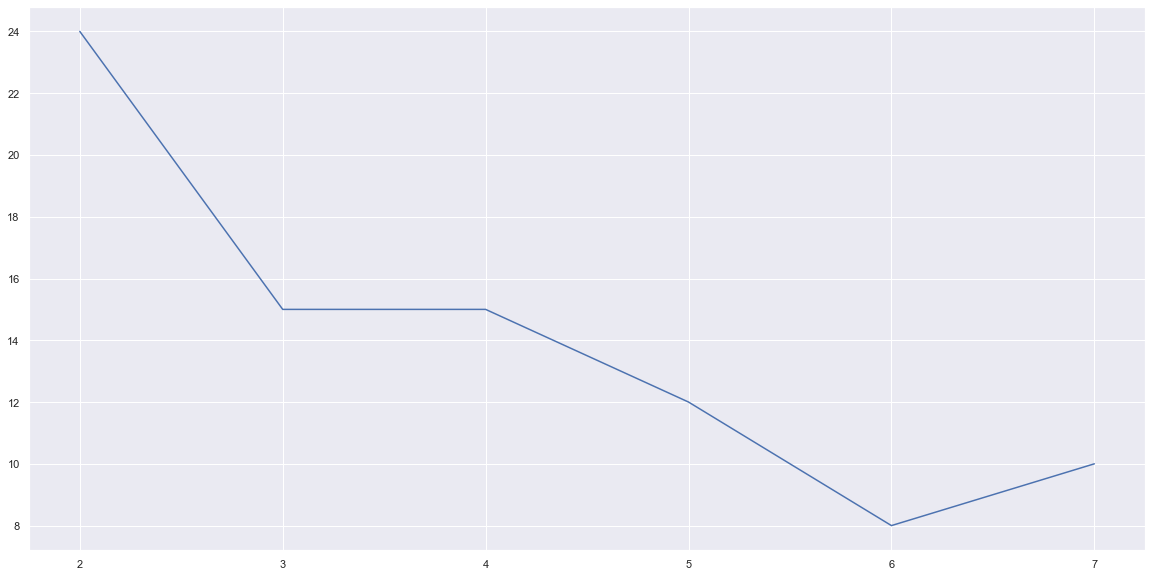

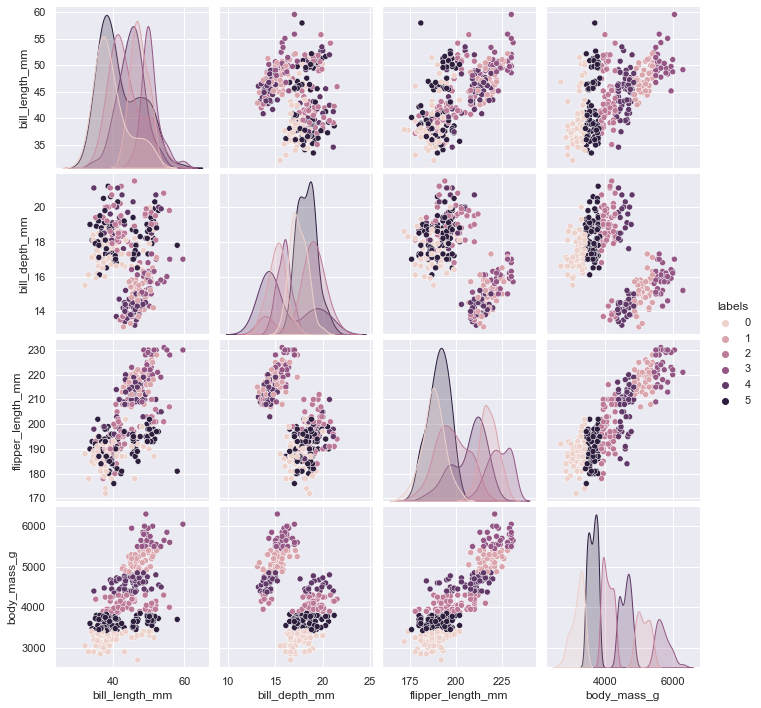

In [68]:
def eval_elbow(score):
    e_score = [score[i] - score[(i + 1) % len(score)] for i in range(len(score))]
    corr_last = e_score.pop()
    e_score.insert(0, corr_last)

    return sorted([[nr, s] for nr, s in zip(range(2, 8), e_score)], key=lambda x: x[1], reverse=True)

def add_score(class_score, counter):
    for i, (classes, score) in enumerate(class_score, 1):
        counter[classes].append(i)

def eval_low(scores, reverse=False):
    return sorted([[nr, s] for nr, s in zip(range(2, 8), scores)], key=lambda x: x[1], reverse=reverse)
    

def eval_scores(scores):
    score_per_class = {nr: [] for nr in range(2, 8)}
    
    elbow = eval_elbow(scores[0])
    silh = eval_low(scores[1])
    calin = eval_low(scores[2], reverse=True)
    db = eval_low(scores[3], reverse=True)

    [add_score(s, score_per_class) for s in [elbow, silh, calin, db]]

    return {k: sum(v) for k, v in sorted(score_per_class.items(), key=lambda item: sum(item[1]))}


e = eval_scores(metrics)
sns.lineplot(x=list(e.keys()), y=list(e.values()))

best_score = list(e.keys())[0]

df['labels'] = all_labels[best_score][0]
sns.pairplot(df, hue='labels');

In [69]:
from sklearn.manifold import TSNE

tsne_df = pd.DataFrame()
t_sne = TSNE()
reduced = t_sne.fit_transform(df.values)

c:\Kod\Skolkod\applicerad_AI\venv\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
c:\Kod\Skolkod\applicerad_AI\venv\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


In [70]:
tsne_df['x'] = reduced[:, 0]
tsne_df['y'] = reduced[:, 1]
tsne_df = pd.concat([tsne_df, pd.DataFrame(pd.DataFrame({f'{nr}_classes': val[0] for nr, val in all_labels.items()}))], axis=1)


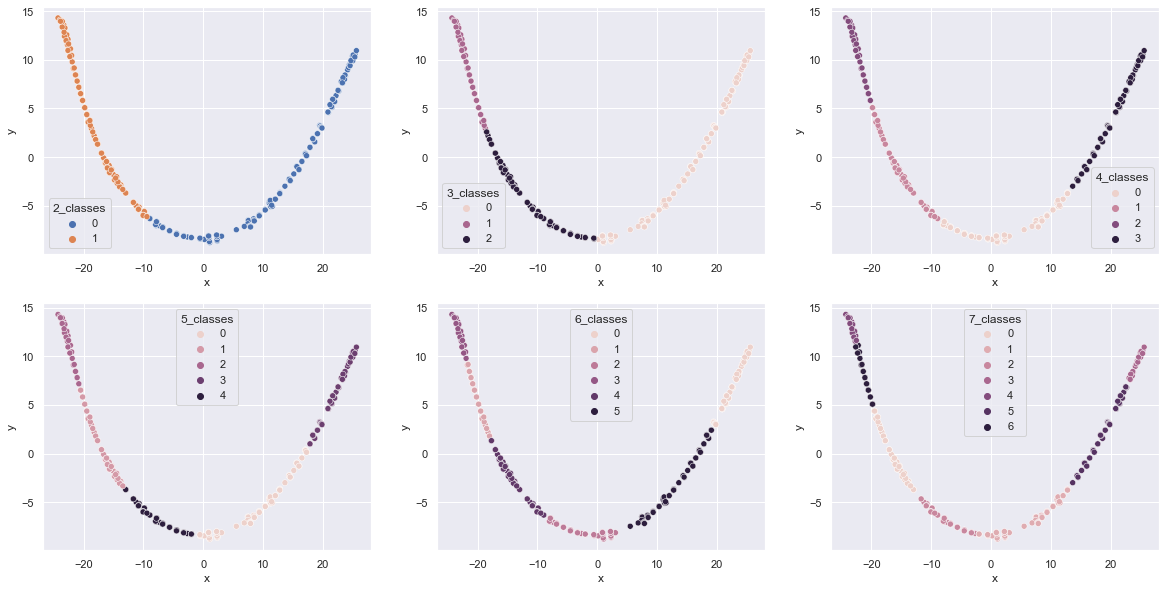

In [71]:
_, axs = plt.subplots(2, 3, figsize=(20, 10))
for i, ax in enumerate(axs.flatten(), min):
    sns.scatterplot(x='x', y='y', hue=f'{i}_classes', data=tsne_df, ax=ax)

In [8]:
import umap
umap_df = pd.DataFrame()
mapper = umap.UMAP(metric='hellinger', n_neighbors=15, min_dist=0.1)

In [9]:
u_data = mapper.fit_transform(df)

In [10]:
umap_df['x'] = u_data[:, 0]
umap_df['y'] = u_data[:, 1]

umap_df = pd.concat([umap_df, pd.DataFrame(pd.DataFrame({f'{nr}_classes': val[0] for nr, val in all_labels.items()}))], axis=1)

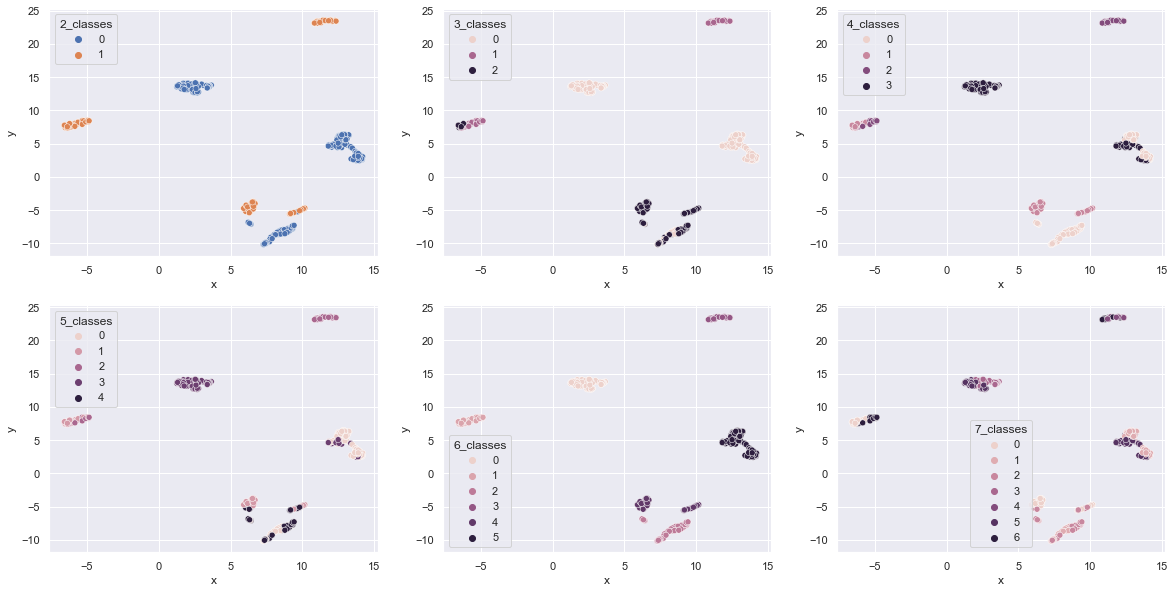

In [11]:
_, axs = plt.subplots(2, 3, figsize=(20, 10))
for i, ax in enumerate(axs.flatten(), min):
    sns.scatterplot(x='x', y='y', hue=f'{i}_classes', ax=ax, data=umap_df)

In [12]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
pca_df = pd.DataFrame()
pca_res = pca.fit_transform(df)

In [13]:
pca_df['x'] = pca_res[:, 0]
pca_df['y'] = pca_res[:, 1]

pca_df = pd.concat([pca_df, pd.DataFrame(pd.DataFrame({f'{nr}_classes': val[0] for nr, val in all_labels.items()}))], axis=1)

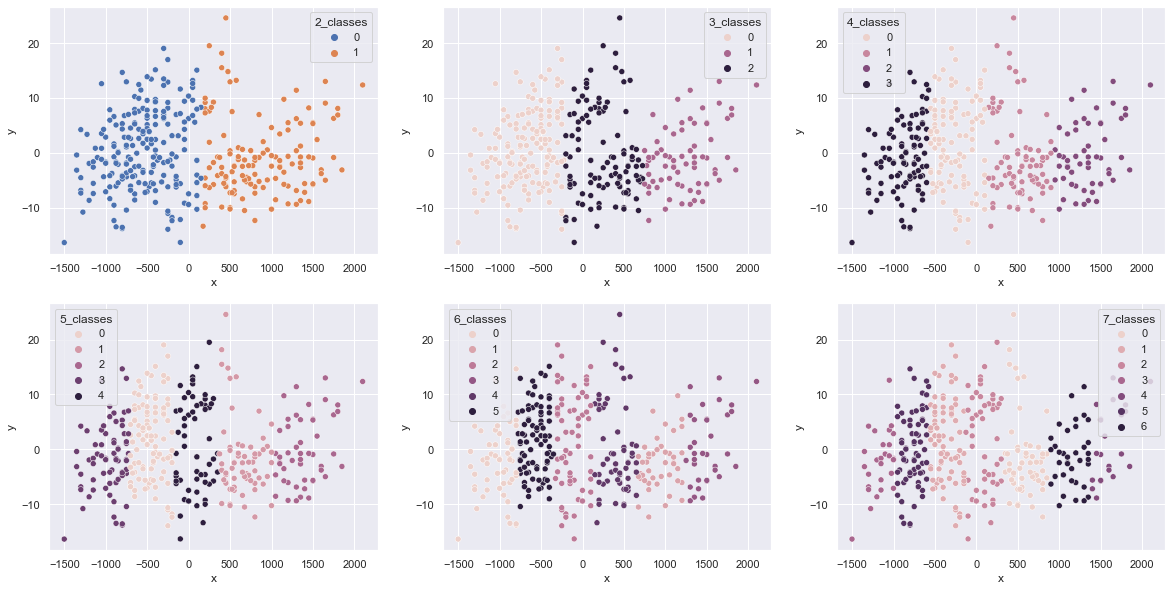

In [14]:
_, axs = plt.subplots(2, 3, figsize=(20, 10))
for nr, ax in enumerate(axs.flatten(), min):
    sns.scatterplot(x='x', y='y', hue=f'{nr}_classes', data=pca_df, ax=ax)

### Gaussian mixture model

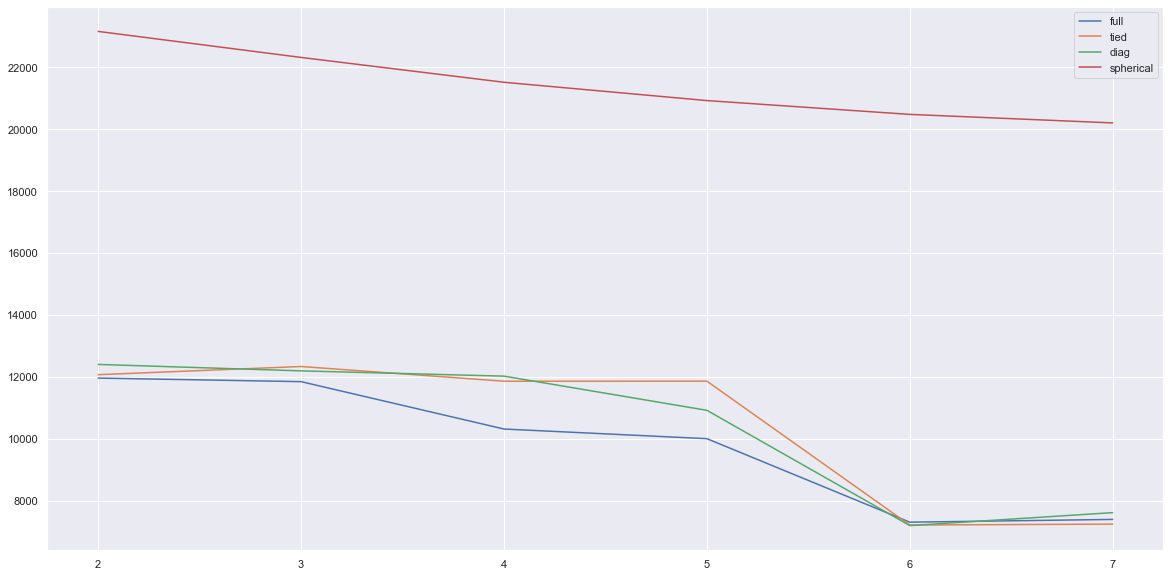

In [15]:
from sklearn.mixture import GaussianMixture

COVARIANCES = ['full', 'tied', 'diag', 'spherical']
MIN, MAX = 2, 8

gmm_models = [GaussianMixture(n_components=nr, covariance_type=covariance).fit(df) for nr in range(MIN, MAX) for covariance in COVARIANCES]
bic_scores = [m.bic(df) for m in gmm_models]

for co in COVARIANCES:
    sns.lineplot(
        x=range(MIN, MAX), 
        y=[score for i, score in enumerate(bic_scores) if gmm_models[i].covariance_type == co], 
        label=co
        )


### DBSCAN

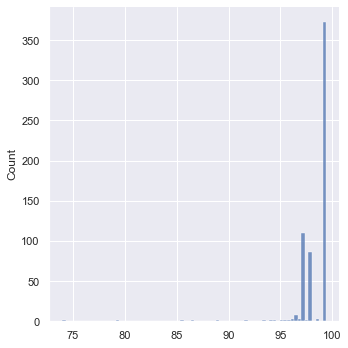

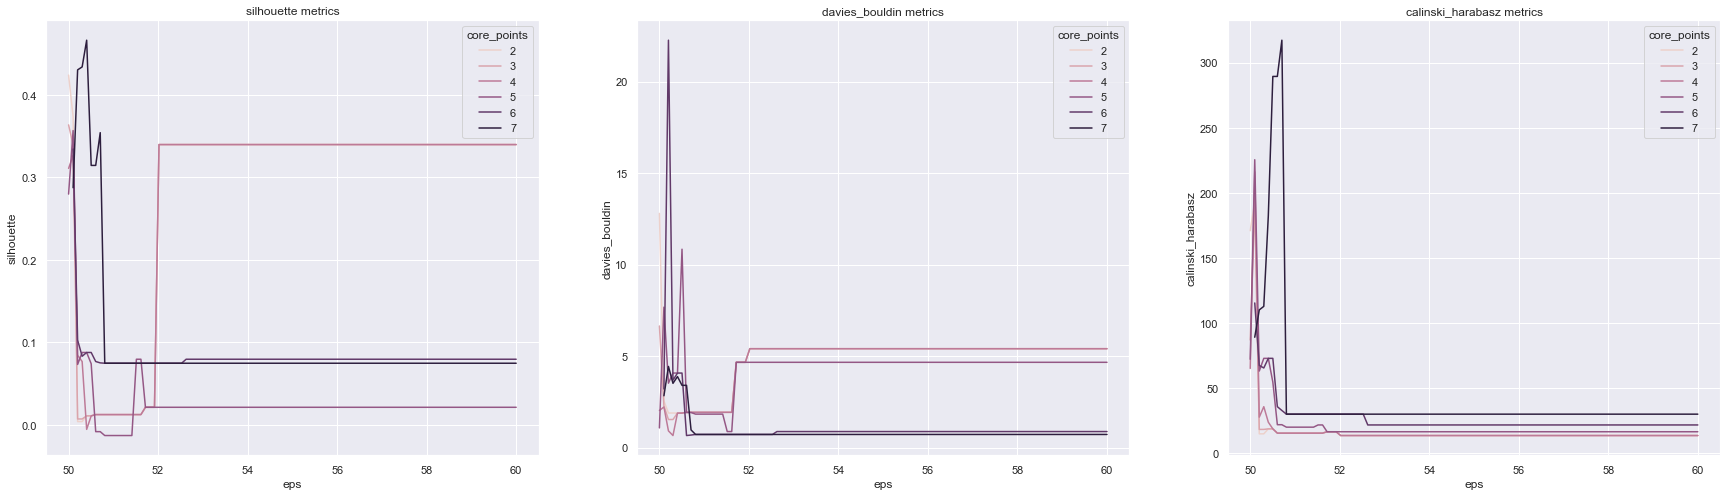

In [26]:
from sklearn.cluster import DBSCAN
from itertools import product

EPS_MIN = 50
EPS_MAX = 60
CORE_POINT_MIN = 2
CORE_POINT_MAX = 8

eps_range = np.linspace(EPS_MIN, EPS_MAX, 100)
core_points_range = np.arange(CORE_POINT_MIN, CORE_POINT_MAX)
names = ['Silhouette Metrics', 'Calinski Harabasz Metrics', 'Davies Bouldin Metrics']
param_combinations = list(product(eps_range, core_points_range))

percentage_labeled = []
scores = {
    'silhouette': [],
    'davies_bouldin': [],
    'calinski_harabasz': [],
    'core_points': [],
    'eps': []
    }

for eps, core_points in param_combinations:
    dbscan = DBSCAN(eps=eps, min_samples=core_points).fit(df)
    labels = dbscan.labels_

    percentage = len(labels[labels >= 0]) / len(labels) * 100
    percentage_labeled.append(percentage)

    if len(np.unique(labels)) > 1 and percentage >= 85:
        scores['silhouette'].append(silhouette_score(df.to_numpy(), labels))
        scores['davies_bouldin'].append(davies_bouldin_score(df.to_numpy(), labels))
        scores['calinski_harabasz'].append(calinski_harabasz_score(df.to_numpy(), labels))
        scores['core_points'].append(core_points)
        scores['eps'].append(eps)

sns.displot(percentage_labeled);
plt.show();

_, axs = plt.subplots(1, 3, figsize=(30, 8))
for ax, score in zip(axs, ['silhouette', 'davies_bouldin', 'calinski_harabasz']):
    sns.lineplot(x='eps', y=score, hue='core_points', data=scores, ax=ax);
    ax.set_title(f'{score} metrics')

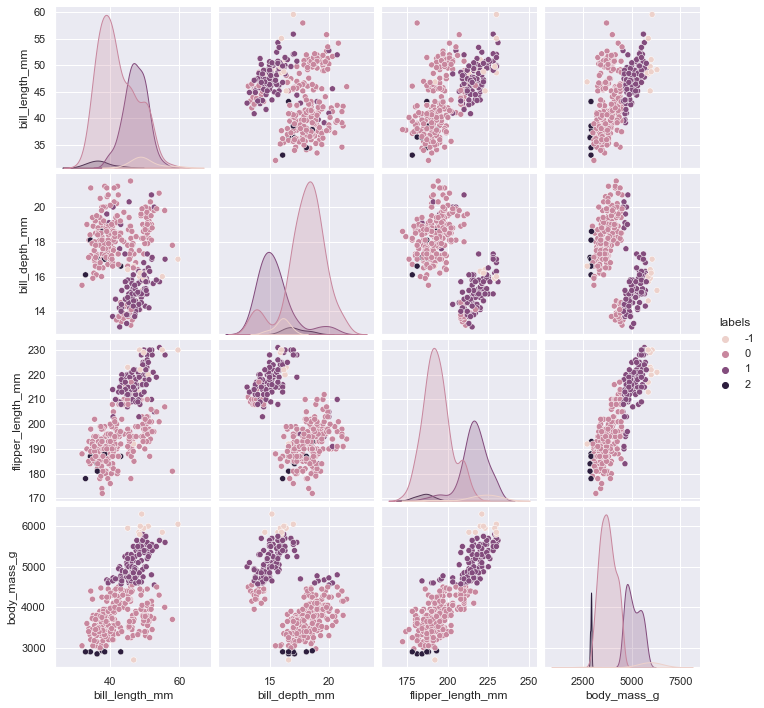

In [27]:
_, eps, cp = sorted(zip(scores['calinski_harabasz'], scores['eps'], scores['core_points']), key=lambda x: x[0], reverse=True)[0]

model = DBSCAN(eps=eps, min_samples=cp).fit(df)

df['labels'] = model.labels_

sns.pairplot(
    df,
    hue='labels'
);